<a href="https://colab.research.google.com/github/ljbcoder/Project-Tensorflow/blob/main/Project_Tensorflow_AI_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#What's Going on: Directly Under the Hood
import numpy as np

I = np.array([[0.05,.10]])
T = np.array([[0,1]])
WH = np.array([[0.15, 0.25],
               [0.2,0.3]])

BH = np.array([[0.35,0.35]])
WO = np.array([[0.4, 0.5],
               [0.45,0.55]])
BO = np.array([[0.6,.6]])

for epoch in range(100000):
  print(epoch)

  #Apply sigmoid to first layer
  H = I @ WH + BH
  H = 1/(1+np.exp(-H))

  #Apply Softmax for second layer
  O = H @ WO + BO
  OM = O - np.max(O)
  O = np.exp(OM)/np.sum(np.exp(OM))

  E = np.sum(-T*np.log(O))
  if E < 0.0001:
    break

  Ob = O - T
  #Nothing for softmax cross entropy error

  Hb = Ob @ WO.T
  Hb = Hb * H * (1-H)

  WHb = I.T @ Hb
  BHb = 1* Hb
  WOb = H.T @ Ob
  BOb = 1 * Ob

  lr = 0.01
  WH = WH - lr * WHb
  BH = BH - lr * BHb
  WO = WO - lr * WOb
  BO = BO - lr - BOb




# **FINAL CODE**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape
x_train = x_train.reshape(-1, 28*28).T / 255.0  # shape: (784, num_samples)
x_test = x_test.reshape(-1, 28*28).T / 255.0

# One-hot encode labels
y_train = to_categorical(y_train).T  # shape: (10, num_samples)
y_test = to_categorical(y_test).T


In [ ]:
#Each image corresponds to a column of x --> 28x28 pixels / 60000 images
#Each Label corresponds to a column of y --> 10 categories / 60000 labels
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of y_test: ",y_test.shape)


Shape of x_train:  (784, 60000)
Shape of y_train:  (10, 60000)
Shape of x_test:  (784, 10000)
Shape of y_test:  (10, 10000)


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

#I put Softmax derivative as implicit: Cancels out with Cross entropy
# def softmax_derivative(z):
#     s = softmax(z)
#     return s * (1 - s) --> This eventually cancels out with 1/s multiplied in the backpropagation step

#Loss Functions
def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def MSE_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true)

def cross_entropy(y_true, y_pred):
    epsilon = 1e-10  # Small value to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # Clip values to avoid log(0)
    return -np.sum(y_true * np.log(y_pred))


def cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true

class ModelLayer:
    def __init__(self, output_size, activation='relu', input_size=None, learning_rate=0.001):
        self.output_size = output_size
        self.input_size = input_size  # Set later if None
        self.activation_name = activation.lower()
        self.activation = None
        self.activation_derivative = None

        self.learning_rate = learning_rate

        self.weights = None  # Will be initialized when input_size is known
        self.bias = None

        self.input_vals = None
        self.z = None

    def build(self, input_size):
        """Initialize weights and biases once input size is known"""
        self.input_size = input_size

        if self.activation_name == 'relu':
            # He initialization (Used mostly for relu, leaky relu) --> Weight initializations to avoid vanishing/exploding gradient
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(2. / input_size)
            self.activation = relu
            self.activation_derivative = relu_derivative

        elif self.activation_name == 'leaky_relu':
            # He initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(2. / input_size)
            self.activation = leaky_relu
            self.activation_derivative = leaky_relu_derivative

        elif self.activation_name == 'sigmoid':
            # Xavier initialization -> (Used mostly for Sigmoid, tanh, softmax) --> Weight initializations to avoid vanishing/exploding gradient
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(1. / input_size)
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative

        elif self.activation_name == 'softmax':
            # Xavier initialization
            self.weights = np.random.randn(self.output_size, input_size) * np.sqrt(1. / input_size)
            self.activation = softmax
            self.activation_derivative = None
        else:
            raise ValueError(f"Unsupported activation: {self.activation_name}")

        self.bias = np.zeros((self.output_size, 1))

    #Forward Propagation
    def pass_forward(self, input_vals):
        if self.weights is None:
            self.build(input_vals.shape[0])
        self.input_vals = input_vals
        self.z = np.dot(self.weights, input_vals) + self.bias
        return self.activation(self.z)

    #Backpropagation
    def pass_backwards(self, dA):
        if self.activation_name == 'softmax':
            dZ = dA  # Softmax derivative is handled implicitly in cross-entropy
        else:
          dZ = dA * self.activation_derivative(self.z)

        dW = np.dot(dZ, self.input_vals.T)
        dB = np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(self.weights.T, dZ)

        self.weights -= self.learning_rate * dW
        self.bias -= self.learning_rate * dB

        return dA_prev

    def reset_weights(self):
        self.build(self.input_size)

class Model:
    def __init__(self,layers = []):
        self.layers = layers
        self.built = False

    def add(self, layer):
        self.layers.append(layer)

    #Builds layers after all layer_sizes have been set
    def _build_layers(self, input_size):
        for layer in self.layers:
            if layer.input_size is None:
                layer.build(input_size)
            input_size = layer.output_size  # next layer's input

    #Set optimizers and loss functions
    def compile(self, optimizer, loss_function):
        self.optimizer = optimizer.lower()

        self.loss_function_name = loss_function.lower()

        #Apply the loss function
        if self.loss_function_name == 'mse':
          self.loss_function = MSE
          self.loss_function_derivative = MSE_derivative

        elif self.loss_function_name == 'cross_entropy':
          self.loss_function = cross_entropy
          self.loss_function_derivative = cross_entropy_derivative

        else:
          raise ValueError(f"Unsupported Loss Function: {loss_function}")

    #Forward Propagation
    def forward(self, x):
        if not self.built:
            self._build_layers(x.shape[0])
            self.built = True

        for layer in self.layers:
            x = layer.pass_forward(x)
        return x

    #Backpropagation
    def backward(self, dLoss):
        for layer in reversed(self.layers):
            dLoss = layer.pass_backwards(dLoss)

    #Train the model!
    def train(self, x, y_true, epochs=20, batch_size = 100, print_every=1):
        if self.optimizer == 'sgd':
            for epoch in range(epochs):
                for start in range(0, len(x[0]), batch_size):  # Process in batches of 100 samples
                    x_batch = x[:, start:start+batch_size]  # Shape: (784, 100)
                    y_batch = y_true[:, start:start+batch_size]  # Shape: (10, 100)

                    # Forward pass
                    y_pred = self.forward(x_batch)  # Shape: (10, 100)

                    # Compute the loss for the entire batch
                    loss = self.loss_function(y_batch, y_pred)  # Shape: (10, 100)
                    dLoss = self.loss_function_derivative(y_batch, y_pred)

                    # Backward pass
                    self.backward(dLoss)

                if epoch % print_every == 0 or epoch == epochs - 1:
                    print(f"Epoch {epoch}, Loss: {loss:.4f}")

        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

    def reset_weights(self):
        for layer in self.layers:
            layer.reset_weights()

    #Predictions are just forward propagations of a given input
    def predict(self, x):
      return self.forward(x)

    #Evaluate the model on test data
    def evaluate(self,x_test, y_test):
        correct = 0
        for i in range(len(x_test[0])):
            current_image = x_test[:, i, None]
            prediction = self.predict(current_image)
            label = y_test[i]
            if np.argmax(prediction) == label:
                correct += 1
        return correct / len(x_test[0]) #Finding the average score of the values




In [ ]:
model = Model()
model.add(ModelLayer(128, activation='relu'))
model.add(ModelLayer(64, activation='relu'))
model.add(ModelLayer(32, activation='relu'))
model.add(ModelLayer(10, activation='softmax'))

model.compile(optimizer="sgd", loss_function="cross_entropy")
model.train(x_train[:, :2000], y_train[:, :2000], epochs=50, print_every=10)


Epoch 0, Loss: 153.2372
Epoch 10, Loss: 13.4542
Epoch 20, Loss: 3.5602
Epoch 30, Loss: 1.4509
Epoch 40, Loss: 0.7617
Epoch 49, Loss: 0.4989


Model Output: 
 [[1.35066060e-10]
 [9.99982961e-01]
 [2.82404498e-08]
 [5.90270649e-08]
 [4.17962946e-06]
 [5.36897510e-07]
 [5.50151986e-08]
 [8.72948886e-06]
 [3.44869935e-06]
 [2.04862295e-09]]
Prediction:  1
Label:  1


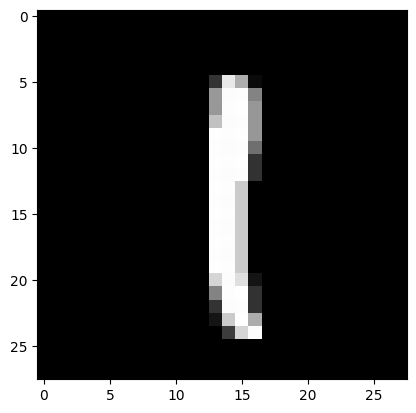

In [ ]:
import random

def test_prediction(index):
    current_image = x_test[:, index, None]
    prediction = model.predict(current_image)
    label = y_test[index]


    print("Model Output: \n", prediction)
    print("Prediction: ", np.argmax(prediction))
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


test_prediction(random.randint(0,len(x_test)))

In [ ]:
#Model Evaluation
model.evaluate(x_test, y_test)

0.9018